Summary

---

This notebook is designed to illustrate the development of authentication / classification models for dense, tabular data.  This illustrates suggested best practices and illustrates key steps.

By the end of the notebook you should understand how to
* Perform basic exploratory data analysis (EDA)
* Check for basic problems with your data (missing values, etc.)
* Perform feature engineering and remove features without any statistical relevance
* Create a model pipeline
* Optimize and assess the pipeline's performance relative to others
* Use a learning curve to assess whether or not to collect more data
* Explain your model using [SHAP](shap.readthedocs.io/)

In [593]:
# Set to false to re-calculate things (expensive and time-consuming); otherwise load results from disk
demonstration = True

In [595]:
# Install necessary repositories
using_colab = 'google.colab' in str(get_ipython())

if using_colab:
    !pip install watermark
    from google.colab import drive
    drive.mount('/gdrive')
    
for repo in ['ml_inspector', 'ml_utils', 'pychemauth']:
    if using_colab:
        !git clone https://github.com/mahynski/$repo
        !cd $repo/; pip install -r requirements.txt
    __import__(repo)

import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import sklearn

# Cython is always nice to have; see https://cython.readthedocs.io/en/latest/src/quickstart/build.html
%load_ext Cython

# Reload modules automatically if updated
%load_ext autoreload
%autoreload 2
    
# This will list all the packages you have imported and their versions for reproducibility
%load_ext watermark
%watermark -t -m -h -v --iversions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Hostname: PN116495

imblearn  : 0.9.0
numpy     : 1.21.5
json      : 2.0.9
pandas    : 1.3.4
numba     : 0.55.1
sklearn   : 1.0.2
shap      : 0.40.0
seaborn   : 0.11.2
matplotlib: 3.5.1
scipy     : 1.7.3
tqdm      : 4.64.0



In [596]:
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
import imblearn
import tqdm
import pickle

import shap
shap.initjs()

# The Data

For this example let's use the famous iris dataset

In [2]:
from sklearn import datasets
data = datasets.load_iris()

print(data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [8]:
X = data['data']
y = np.array([data['target_names'][i] for i in data['target']])

In [185]:
df = pd.DataFrame(data=X, columns=data['feature_names'])
df['species'] = y

# Exploratory Data Analysis (EDA)

## Summarize the Raw Data

It is usually best to start by examining a summary of the data.

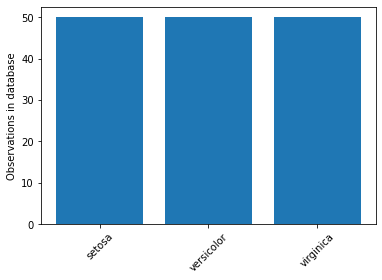

In [9]:
plt.bar(
    x=np.unique(y),
    height=[np.sum(y==class_) for class_ in np.unique(y)]
)
plt.ylabel('Observations in database')
_ = plt.xticks([0, 1, 2], [class_ for class_ in np.unique(y)], rotation=45)

## Impute Missing Values

We also should perform some standard checks to see if the data has any missing values.

In [10]:
from ml_utils.eda.screen import RedFlags

r = RedFlags()
r.run(X, y)

This dataset has no issues with it because it is well curated, but you may sometimes find issues with missing data, repeated values, etc.  We can simulate a gappy dataset by deleting some values at random.


In [11]:
X_bad = X.copy()
np.random.seed(42)

n_delete = 7
to_delete = list(zip(
    [np.random.randint(X_bad.shape[0]) for i in range(n_delete)],
    [np.random.randint(X_bad.shape[1]) for i in range(n_delete)]
))

mask = np.ones_like(X_bad).astype(bool)
for i,j in to_delete:
    X_bad[i,j] = np.nan

In [12]:
r.run(X_bad, y)

C:\Users\nam4\OneDrive - NIST\Documents\GitHub\ml_utils\eda\screen.py:93: UserWarning: X contains NaN values; this will require imputation
  warnings.warn("X contains NaN values; this will require imputation")


Let's use PCA to iteratively fill in the missing values.  You may also want to take a look at:
* pychemauth.preprocessing.missing.LOD to impute values below the limit of detection
* pychemauth.preprocessing.missing.PLS_IA using PLS as a supervised alternative to PCA-based imputation

In practice, except for LOD, these imputation schemes have hyperparameters which should be tuned via CV as part of the pipeline.  This will be addressed later.

In [13]:
from pychemauth.preprocessing.missing import PCA_IA

itim = PCA_IA(n_components=1, missing_values=np.nan, tol=1.0e-6, max_iters=1000)
X_fixed = itim.fit_transform(X_bad)

## Visualize the Data

First, let's just look at the data globally with PCA to see how it is laid out in the first few PCs.

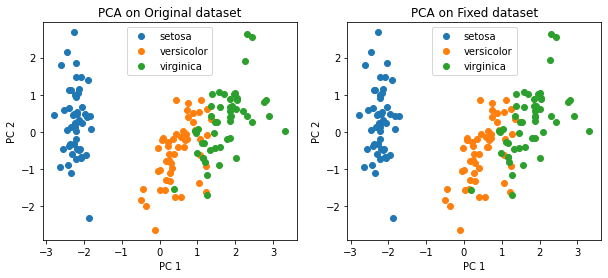

In [15]:
%matplotlib inline 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

def project(X, ax, title=None):
    pca = PCA(n_components=2)
    ss = StandardScaler()
    X_proj = pca.fit_transform(ss.fit_transform(X))

    for class_ in np.unique(y):
        mask = y == class_
        ax.plot(X_proj[mask,0], X_proj[mask,1], 'o', label=class_)
    ax.legend(loc='best')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title(title)
    
project(X, axes[0], title='PCA on Original dataset')
project(X_fixed, axes[1], title='PCA on Fixed dataset')

In [16]:
%matplotlib notebook

pca = PCA(n_components=3)
ss = StandardScaler()
X_proj = pca.fit_transform(ss.fit_transform(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for class_ in np.unique(y):
    mask = y == class_ 
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=class_)
ax.legend(loc='best')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('PCA on Original dataset')

<IPython.core.display.Javascript object>

Text(0.5, 0.92, 'PCA on Original dataset')

Next, let's look at the pairwise distribution of features.

In [23]:
# Pairwise, these features show some separation/clustering suggesting that classification is likely to 
# be successful.
sns.pairplot(df, 
             vars=data['feature_names'],
             diag_kind='auto',
             hue='species',
             palette='viridis'
            )

<IPython.core.display.Javascript object>

## Basic Cluster Analysis with KMeans++

In [ ]:
ss = pychemauth.preprocessing.scaling.CorrectedScaler()
X_std = ss.fit_transform(X)
ml_inspector.data.InspectData.cluster_elbow(X_std, clusters=np.arange(1,100,5)) 

for nc in [2, 3, 4]:
    km = KMeans(n_clusters=nc,
            init='k-means++',
            n_init=10,
            random_state=0)
    plt.figure()
    ml_inspector.data.InspectData.cluster_silhouette(X_std, km)

In [ ]:
def make_clusters(nc, X_std, y, display=True):
    """
    Examine the make up of different clusters.
    
    Notes
    -----
    This uses Euclidean distances so be sure to standardize the data before using this.
    """
    y = np.array(y)
    X_std = np.array(X_std)

    km = KMeans(n_clusters=nc,
                init='k-means++',
                n_init=10,
                random_state=0)

    enc = LabelEncoder()
    pred = km.fit_predict(X_std, enc.fit_transform(y))
    nt = len(enc.classes_)
    
    if (display):
        fig, axes = plt.subplots(nrows=nc, ncols=1, figsize=(5,20))
        cluster_content = {}
        for cluster,ax in enumerate(axes):
            cluster_content[cluster] = np.unique(y[pred == cluster])
            ax.hist(enc.transform(y[pred == cluster]), 
                     bins=[-0.5]+[0.5+i for i in range(nt)])
            ax.set_title('Cluster {}'.format(cluster))
            ax.set_xticks(np.arange(nt))
            ax.set_xticklabels(enc.inverse_transform(np.arange(nt)), rotation='vertical')
        plt.tight_layout()
    else:
        cluster_content = {}
        for cluster in np.arange(nc):
            cluster_content[cluster] = np.unique(y[pred == cluster])
    
    return cluster_content

In [ ]:
_ = make_clusters(2, X_std, y)

## Use Jensen-Shannon Divergence to Suggest Class Mergers

Let's combine different classes to see if any group of them is particularly distinguishable from the rest.

In [24]:
from ml_utils.eda.screen import JSScreen as JSC

In [63]:
jsc = JSC(n=2, feature_names=data['feature_names'], js_bins=25, 
          robust=True # We don't know if there are any outliers so use robust method by default when starting out
         )
_ = jsc.fit(X, y)

100%|██████████| 3/3 [00:00<00:00, 106.99it/s]

100%|██████████| 2/2 [00:00<00:00, 33.31it/s]


In [143]:
fig = plt.figure(figsize=(12,6))
jsc.visualize_grid(fig.gca())
plt.tight_layout()
fig.patch.set_facecolor('white')

<IPython.core.display.Javascript object>

In [142]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12,12))
jsc.visualize_max(ax=axes.ravel())
plt.tight_layout()

<IPython.core.display.Javascript object>

Here we see that setosa is easily distinguished from the other 2 by petal properties; the same is true for versicolor and virginica.  This is a fairly easy dataset to work with!  Combining categories into pairs does not seem to make that pair more distinguishable than its members.

In [84]:
fig = plt.figure()
fig.patch.set_facecolor('white')
vm = jsc.visualize_classes(method='max', ax=fig.gca())

<IPython.core.display.Javascript object>

In [65]:
# This is the most useful tool for looking for pairs to combine
from ml_utils.eda.screen import JSBinary

jsb = JSBinary(js_bins=25)
_ = jsb.fit(X, y)
jsb.visualize()

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Maximum Pairwise $\\nabla \\cdot JS$'}>

In [175]:
# Look at how the average JSD is a function of the number of bins (equivalently, bin size)
ave = []
for bins in range(1, 50, 2):
    jsb = JSBinary(js_bins=bins)
    _ = jsb.fit(X, y)
    ave.append([bins, np.mean(jsb.matrix[np.triu_indices(3, k=1)])])
    
ave = np.array(ave)
plt.figure()
plt.plot(ave[:,0], ave[:,1])

## UMAP to Suggest Class Mergers

In [ ]:
# Also consider other unsupervised clustering methods
# PCA can serve as a linear method for this purpose as well

# Basic Feature Engineering

## Polynomial Feature Engineering

In [597]:
pf = PF(degree=3)
X_poly = pf.fit_transform(X)

In [145]:
X_poly.shape

(150, 35)

In [147]:
X.shape

(150, 4)

In [600]:
pf.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3',
       'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2', 'x0^3',
       'x0^2 x1', 'x0^2 x2', 'x0^2 x3', 'x0 x1^2', 'x0 x1 x2', 'x0 x1 x3',
       'x0 x2^2', 'x0 x2 x3', 'x0 x3^2', 'x1^3', 'x1^2 x2', 'x1^2 x3',
       'x1 x2^2', 'x1 x2 x3', 'x1 x3^2', 'x2^3', 'x2^2 x3', 'x2 x3^2',
       'x3^3'], dtype=object)

## BorutaSHAP

In [253]:
from BorutaShap import BorutaShap

In [254]:
from sklearn.ensemble import RandomForestClassifier as RF

model = RF(n_estimators=20, criterion='gini', random_state=0, class_weight='balanced')

selector = BorutaShap(model=model, 
                      importance_measure='shap', # If 'shap': uses shap.TreeExplainer(self.model, feature_perturbation = "tree_path_dependent")
                      classification=True, 
                      percentile=100, pvalue=0.05 # These are default values to behave like the original R package
                     )

In [251]:
# Fit the feature selector
# Train vs. test is an open question: https://compstat-lmu.github.io/iml_methods_limitations/pfi-data.html#introduction-to-test-vs.training-data
selector.fit(X=df.drop(['species'], axis=1),  # Must be a Pandas DataFrame
             y=df['species'], 
             n_trials=100, 
             sample=False, # Use KS-test to choose a sample of the data to compute importance values on instead of entire dataset (for speed)
             train_or_test='train', 
             normalize=True, # Normalize metric (i.e., shap value importance) by (x-x_mean)/x_std
             verbose=True,
             random_state=0 # For reproducibility, but only relevant if model in selector is also specified
            )

# If train_or_test == 'train' model is trained and evaluated on same data (entirely of X provided); however,
# if 'test', a train_test_split with a 70:30 of X using the random_state value when fit() is called (see below).

# The Bonferroni correction for multiple comparisons is used, as in the original R version of Boruta

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['petal width (cm)', 'sepal width (cm)', 'sepal length (cm)', 'petal length (cm)']
0 attributes confirmed unimportant: []
0 tentative attributes remains: []


In [252]:
selector.accepted

['petal width (cm)',
 'sepal width (cm)',
 'sepal length (cm)',
 'petal length (cm)']

In [193]:
selector.plot(which_features='all')

<IPython.core.display.Javascript object>

## Feature Variances

Features that are fairly constant (low variance) are sometimes not very useful, so it is worth checking if you have any present.

In [200]:
variances = dict(df.drop(['species'], axis=1).std())
keys = variances.keys()

In [206]:
plt.figure()
plt.bar(
    x=np.arange(len(keys)),
    height=[variances[k] for k in keys]
)
plt.ylabel('Standard Deviation')
_ = plt.xticks(np.arange(len(keys)), keys, rotation=45)

<IPython.core.display.Javascript object>

See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection for more details

# Building a Pipeline

In [425]:
# Let's build a model for setosa
target_class = 'setosa'

In [426]:
from ml_utils.sklearn_ext.feature_selection import JensenShannonDivergence as JS
from ml_utils.sklearn_ext.feature_selection import PipeBorutaSHAP
from ml_utils.sklearn_ext.imbalanced import ScaledSMOTEENN
from pychemauth.preprocessing.scaling import CorrectedScaler
from pychemauth.classifier.simca import SIMCA_Classifier

pipeline = imblearn.pipeline.Pipeline(steps=[
    ('impute_missing', PCA_IA(
        n_components=1, 
        missing_values=np.nan, 
        tol=1.0e-2, 
        max_iters=1000)),
    ('feature_engineer', PF(degree=3)),
    ('feature_eliminator', PipeBorutaSHAP(
        model=RF(n_estimators=20, criterion='gini', random_state=0, class_weight='balanced'), 
        classification=True, 
        percentile=100, pvalue=0.05)), # This removes all features with no statistical signal
    ('feature_selector', JS(
        top_k=5, 
        per_class=False, 
        bins=25, 
        threshold=0.5)), # This keeps just the "best" features, as determined by JSD
    # Could add an outlier detection routine here, too.
    ('class_balancer', ScaledSMOTEENN(
        random_state=1,
        k_enn=3,
        k_smote=3,
        kind_sel_enn='all')), # Balance classes (in this example this is not necessary)
    ('feature_scaling', CorrectedScaler(
        with_mean=True, 
        with_std=True, 
        pareto=False)), # This may or may not be necessary; SIMCA does internal scaling anyway
    ('model', SIMCA_Classifier(
        n_components=1, 
        alpha=0.05, 
        scale_x=True, 
        style='dd-simca', 
        target_class='setosa',
        use='TEFF',
        iterate=False)),
])

In [427]:
param_grid = [{
    'impute_missing__n_components':[1, 3],
    'feature_engineer__degree':[2, 3],
    'feature_eliminator__model':[
        RF(n_estimators=10, criterion='gini', random_state=0, class_weight='balanced'),
        RF(n_estimators=10, criterion='gini', random_state=0, class_weight=None),
    ],
    'feature_selector__top_k':[3, 5],
    'feature_selector__bins':[5, 10, 25],
    'feature_selector__threshold':[0.5, 0.8],
    'class_balancer__k_enn':[1, 3], 
    'class_balancer__k_smote':[1, 3], 
    'class_balancer__kind_sel_enn':['all', 'mode'],
    'feature_scaling__with_mean':[True],
    'feature_scaling__with_std':[True],
    'feature_scaling__pareto':[True, False],
    'model__n_components':[1, 2, 3],
    'model__alpha':[0.05],
    'model__style':['dd-simca'],
    'model__scale_x':[True],
    'model__iterate':[True, False]
}]

# Training the Pipeline

In [430]:
from sklearn.model_selection import GridSearchCV
from ml_utils.sklearn_ext.cross_validation import NestedCV

def final_fit(X, y, pipeline, param_grid):
    """CV on entire dataset, retrain on full set at the end."""
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=3, 
            shuffle=True, 
            random_state=0,
        ),
        error_score=0,
        refit=True # Re-fit the model on the entire dataset
    )
    
    gs.fit(X, y) 
    
    return gs

def get_nested_scores(pipeline, param_grid, X, y, k_inner=2, k_outer=5):
    """Nested CV for statistical comparisons."""
    NCV = NestedCV(k_inner=k_inner, k_outer=k_outer)
    return NCV.grid_search(pipeline, param_grid, X, y, classification=True)

## NestedCV

First estimate the pipeline's performance and uncertainty

In [431]:
if not demonstration:
    pipe1_scores = get_nested_scores(
        pipeline, 
        param_grid, 
        X_bad, 
        y, 
        k_inner=2, 
        k_outer=5
    )
    pickle.dump(pipe1_scores, open('pipeline_scores.pkl', 'wb'))
else:
    pipe1_scores = pickle.load(open('pipeline_scores.pkl', 'rb'))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [432]:
# This does k_outer test/train splits and uses k_inner (stratified) CV to optimize the hyperparameters of the model.
# Overall, this simulates multiple different test/train data sets/splits and tells you an average performance
# the pipeline is likely to yield given a certain train set, then tested on real world data later on.  We can use
# this to estimate what the generalization error would be if we trained on ALL our available data then put the
# pipeline into production.  In this scenario, we have no test set available; that would come as time goes on.  We
# want to know how the best model we can get would perform +/- uncertainty, which is what nested CV provides.

In [436]:
print('The estimated performance is {} +/- {}'.format(
    '%.3f'%(np.mean(pipe1_scores)),
    '%.3f'%(np.std(pipe1_scores))
))

The estimated performance is 97.16% +/- 3.17%


## K-fold CV

Re-train the best model on the ENTIRE dataset, since only (k_outer-1)/k_outer was used (even after refit) above

In [440]:
if not demonstration:
    gs = final_fit(df.drop(['species'], axis=1), df['species'], pipeline, param_grid)
    pickle.dump(gs, open('simca_final.pkl', 'wb'))
else:
    gs = pickle.load(open('simca_final.pkl', 'rb'))

  0%|          | 0/20 [00:00<?, ?it/s]

In [441]:
gs.best_params_

{'class_balancer__k_enn': 1,
 'class_balancer__k_smote': 1,
 'class_balancer__kind_sel_enn': 'all',
 'feature_eliminator__model': RandomForestClassifier(class_weight='balanced', n_estimators=10, random_state=0),
 'feature_engineer__degree': 2,
 'feature_scaling__pareto': True,
 'feature_scaling__with_mean': True,
 'feature_scaling__with_std': True,
 'feature_selector__bins': 5,
 'feature_selector__threshold': 0.5,
 'feature_selector__top_k': 5,
 'impute_missing__n_components': 1,
 'model__alpha': 0.05,
 'model__iterate': False,
 'model__n_components': 2,
 'model__scale_x': True,
 'model__style': 'dd-simca'}

In [603]:
gs.cv_results_['mean_test_score']

array([0.93768069, 0.92528748, 0.        , ..., 0.93662966, 0.93662966,
       0.93662966])

In [604]:
gs.score(X_bad, y) 

# This is biased because it is not based on a held out test set.  The real estimate of performance is from the 
# nested CV loop.  However, it is clearly within that range.

0.9695359714832658

In [453]:
# You can save the preprocessing as separate step
extracted_preprocessing = imblearn.pipeline.Pipeline(
    steps=gs.best_estimator_.steps[:-1]
)

# You can also extract the final model
extracted_model = gs.best_estimator_.steps[-1][1]

In [445]:
np.all(extracted_model.predict(extracted_preprocessing.transform(X_bad)) == gs.predict(X_bad))

True

<IPython.core.display.Javascript object>


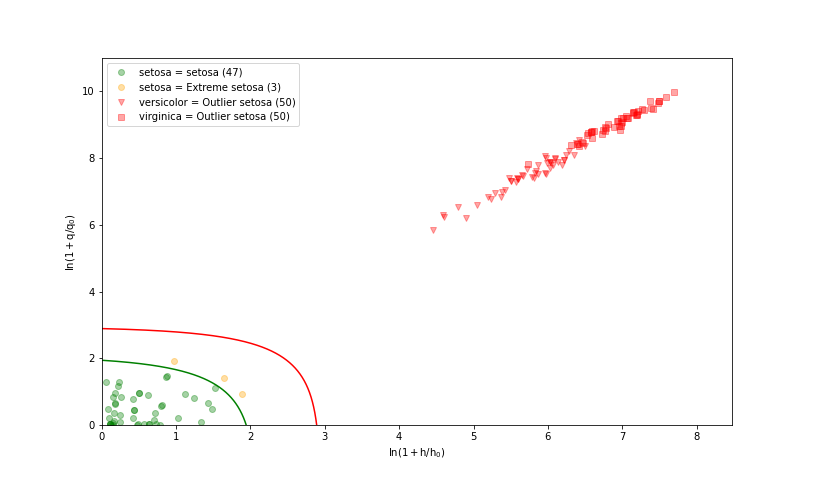

In [446]:
xform = extracted_preprocessing.transform(X_bad)
extracted_model.model.visualize(xform, y)
plt.legend(loc=0)

In [447]:
# We can also inspect different parts of the pipeline

print('The Polynomial Feature Engineer took in {} features and returns {}'.format(
    extracted_preprocessing.named_steps['feature_engineer'].n_features_in_,
    extracted_preprocessing.named_steps['feature_engineer'].n_output_features_
))

# Note the ordering is not sorted by integers
print('The output features are products of input columns; the exponents on these features accepted by BorutaSHAP are :')
boruta_accepted = [(i, extracted_preprocessing.named_steps['feature_engineer'].powers_[int(i)]) for i in 
                   np.array(extracted_preprocessing.named_steps['feature_eliminator'].accepted)]
boruta_accepted

The Polynomial Feature Engineer took in 4 features and returns 15
The output features are products of input columns; the exponents on these features accepted by BorutaSHAP are :


[('12', array([0, 0, 2, 0], dtype=int64)),
 ('14', array([0, 0, 0, 2], dtype=int64)),
 ('13', array([0, 0, 1, 1], dtype=int64)),
 ('3', array([0, 0, 1, 0], dtype=int64)),
 ('7', array([1, 0, 1, 0], dtype=int64)),
 ('8', array([1, 0, 0, 1], dtype=int64)),
 ('11', array([0, 1, 0, 1], dtype=int64)),
 ('5', array([2, 0, 0, 0], dtype=int64)),
 ('10', array([0, 1, 1, 0], dtype=int64))]

In [448]:
# Note that petal length (3rd column) is the only original feature kept.  This makes sense when you look at the
# pairplots of the original data in EDA.
data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

<IPython.core.display.Javascript object>


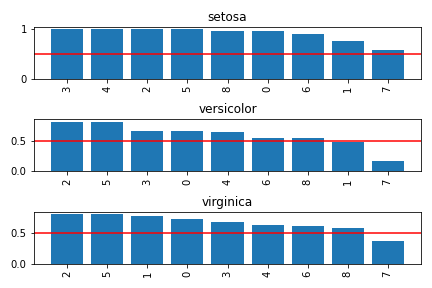

In [449]:
# BorutaSHAP output 9 new feature columns which are sent to the JSD feature selector

# You can look at the JSDs explicitly, or see them plotted...
# extracted_preprocessing.named_steps['feature_selector'].divergence

# The features get a new index (0-8) now and ignore their old indices
extracted_preprocessing.named_steps['feature_selector'].visualize(
    threshold=extracted_preprocessing.named_steps['feature_selector'].threshold
)

In [450]:
print('With per_class=False in the JSD, we select the top {} overall performers'.format(
    extracted_preprocessing.named_steps['feature_selector'].top_k
))

With per_class=False in the JSD, we select the top 5 overall performers


In [451]:
# The polynomical engr features JSD chose are:

mask = extracted_preprocessing.named_steps['feature_selector']._JensenShannonDivergence__mask_
np.array(boruta_accepted)[mask]

array([['12', array([0, 0, 2, 0], dtype=int64)],
       ['13', array([0, 0, 1, 1], dtype=int64)],
       ['3', array([0, 0, 1, 0], dtype=int64)],
       ['7', array([1, 0, 1, 0], dtype=int64)],
       ['8', array([1, 0, 0, 1], dtype=int64)]], dtype=object)

In [452]:
# Let's check this for ourselves
X_before_scaling = extracted_preprocessing.named_steps['feature_scaling'].inverse_transform(
    extracted_preprocessing.transform(X)
)

x1 = X[:,2]**2     # ['12', array([0, 0, 2, 0]
x2 = X[:,2]*X[:,3] # ['13', array([0, 0, 1, 1], dtype=int64)]
x3 = X[:,2]        # ['3', array([0, 0, 1, 0], dtype=int64)]
x4 = X[:,0]*X[:,2] # ['7', array([1, 0, 1, 0], dtype=int64)]
x5 = X[:,0]*X[:,3] # ['8', array([1, 0, 0, 1], dtype=int64)]

assert(np.all(np.isclose(X_before_scaling[:,0], x1)))
assert(np.all(np.isclose(X_before_scaling[:,1], x2)))
assert(np.all(np.isclose(X_before_scaling[:,2], x3)))
assert(np.all(np.isclose(X_before_scaling[:,3], x4)))
assert(np.all(np.isclose(X_before_scaling[:,4], x5)))

# Comparing Different Pipelines

We can also use nested CV to estimate the performance of other pipelines, then use corrected t-tests to determine if one is statistically superior to another.

In [454]:
from pychemauth.classifier.plsda import PLSDA

# Re-use the same preprocessing, but with a different model now
steps = extracted_preprocessing.steps + [
    ('model', PLSDA(
        n_components=3, 
        alpha=0.05,
        gamma=0.01,
        scale_x=True, 
        not_assigned='UNKNOWN',
        style='soft', 
        score_metric='TEFF')
    )
]

pipeline_alt = imblearn.pipeline.Pipeline(steps=steps)

In [459]:
preprocessing_grid = dict([(k,v) for k,v in param_grid[0].items() if not (k.startswith('model__'))])
model_grid = {'model__n_components':np.arange(1, 10, 2),
              'model__alpha': [0.05], 
              'model__scale_x': [True], 
             }

param_grid_alt = preprocessing_grid
for k,v in model_grid.items():
    param_grid_alt[k] = v

In [461]:
if not demonstration:
    pipe_alt_scores = get_nested_scores(
        pipeline_alt, 
        param_grid_alt, 
        X_bad, 
        y, 
        k_inner=2, 
        k_outer=5
    )
    pickle.dump(pipe_alt_scores, open('pipeline_alt_scores.pkl', 'wb'))
else:
    pipe_alt_scores = pickle.load(open('pipeline_alt_scores.pkl', 'rb'))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [476]:
print('The estimated performance of this new pipeline is {} +/- {}'.format(
    '%.3f'%np.mean(pipe_alt_scores),
    '%.3f'%np.std(pipe_alt_scores)
))

The estimated performance of this new pipeline is 0.950 +/- 0.018


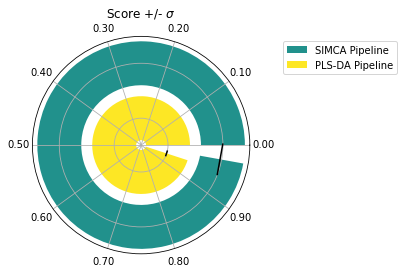

In [467]:
from ml_inspector.model import Compare

%matplotlib inline

results = {
    'SIMCA Pipeline': pipe1_scores,
    'PLS-DA Pipeline': pipe_alt_scores,
}

plt.figure()
_ = Compare.visualize(results, n_repeats=5, alpha=0.05)

In [472]:
# PLS-DA's mean performance is lower, but not statistically significant.

# Justifying Future Work

Question: How much better will your pipeline get if you collected more data?  If you can answer this you can determine how much benefit (e.g., financially) you will get for a certain investment to collect more data. See scikit-learn's [documentation](https://scikit-learn.org/stable/modules/learning_curve.html) for more information.

This assumes the hyperparameters of the model are fixed, and just trains to fit the model parameters

Note that using very small training sets can also cause issues; this is because interpolation, SMOTE, etc. often rely on a minimum number of examples or dimensions because the model was trained with so much more data than it is being given.

In [566]:
from ml_inspector.model import InspectModel
import copy

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

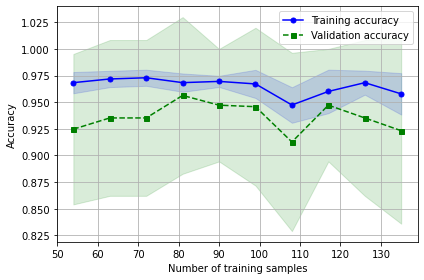

In [591]:
_ = InspectModel.learning_curve(
    model=copy.deepcopy(gs.best_estimator_),
    X=df.drop(['species'], axis=1), 
    y=df['species'],
    train_sizes=np.linspace(0.4, 1, 10), 
    cv=sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
)

In [ ]:
# Unsurprisingly, this model is basically saturated and is not improve expected to improve with more data.

# Explaining Your Model

[SHAP](https://shap.readthedocs.io/) is powerful tool for explaining any black box model.  Using "glassbox" or inspectable models is usually preferable when it comes to understanding this model, legacy models do not always have this feature.

## A Discrimination Baseline

Let's use a random forest to try to fit the data and see how it uses the information available

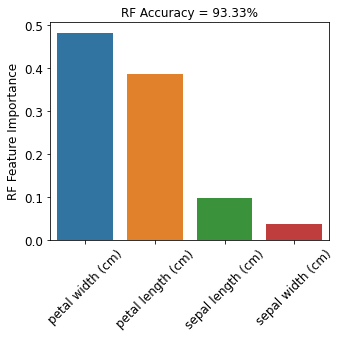

In [480]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def random_forest_importances(X, y, columns, test_size=0.2, n_estimators=100, ax=None):
    """
    Preliminary estimate of feature importance based on random forests.
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=feature%20importance#sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    forest.fit(X_train, y_train) # Tree-based classifiers do not need scaling/normalization

    importances = sorted(list(zip(columns, forest.feature_importances_)), key=lambda x:x[1], reverse=True)

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5,4))
        importance_df = pd.DataFrame(
            columns=['Element', 'Importance'],
            data=importances,
        )
        plt.xticks(rotation=45)
        _ = sns.barplot(data=importance_df, x='Element', y='Importance', ax=ax, orient='v')

    ax.set_xlabel('')
    ax.set_ylabel('RF Feature Importance', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    score = forest.score(X_test, y_test)
    ax.set_title('RF Accuracy = {}%'.format('%.2f'%(100*score)), fontsize=12)
    
    return importances, forest

importances, forest = random_forest_importances(
    X,
    y, 
    columns=data['feature_names'],
    test_size=0.2, 
    n_estimators=100
)

## Explain our Pipeline

In [ ]:
# SHAP samples from the background training set you give it, so you cannot give it gappy data.
# The best option is to run the preprocessing steps involving imputation first to create X_background.

# If you are using non-gappy data, you can use the model directly and feed X_train as the X_background

In [512]:
# Complete pipeline
gs.best_estimator_

Pipeline(steps=[('impute_missing',
                 <pychemauth.preprocessing.missing.PCA_IA object at 0x0000021669F93648>),
                ('feature_engineer', PolynomialFeatures()),
                ('feature_eliminator',
                 <ml_utils.sklearn_ext.feature_selection.PipeBorutaSHAP object at 0x0000021669F93588>),
                ('feature_selector',
                 <ml_utils.sklearn_ext.feature_selection.JensenShannonDivergence object at 0x0000021669F93348>),
                ('class_balancer',
                 <ml_utils.sklearn_ext.imbalanced.ScaledSMOTEENN object at 0x00000216745D9848>),
                ('feature_scaling',
                 <pychemauth.preprocessing.scaling.CorrectedScaler object at 0x000002165B1AA508>),
                ('model',
                 SIMCA_Classifier(n_components=2, target_class='setosa'))])

In [513]:
# Initial filling of gappy data
step_1 = copy.deepcopy(gs.best_estimator_.named_steps['impute_missing'])

# The rest of the pipeline
step_2 = imblearn.pipeline.Pipeline(steps=
    gs.best_estimator_.steps[1:] # All steps afterward
)

In [514]:
X_background = step_1.transform(X_bad)
model = step_2 

In [515]:
# Let's examine how the model made its decisions on the training set
shap_values_train = {}

explainer = shap.KernelExplainer(
    model = model.predict_proba, 
    data = X_background, # shap.sample(X_background, 10, random_state=0),
)
    
shap_values = explainer.shap_values(X_background, 
                                    nsamples='auto', # Can increase for lower variance
                                   )[0] # Just save inlier class results

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/150 [00:00<?, ?it/s]

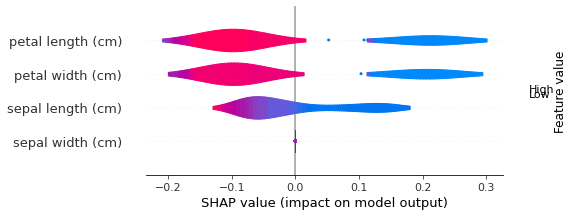

<Figure size 432x288 with 0 Axes>

In [516]:
# Very similar to how RF uses its data.
# In this particular case, we get the additional insight that there is a gap between "high" and "low" values of
# petal properties for setosa (vs. others) which suggests a disrete cutoff between that class and others.
shap.summary_plot(
    shap_values=shap_values,
    features=X_background,
    feature_names=data['feature_names'],
    plot_type='violin',
    max_display=7
    )
plt.tight_layout()

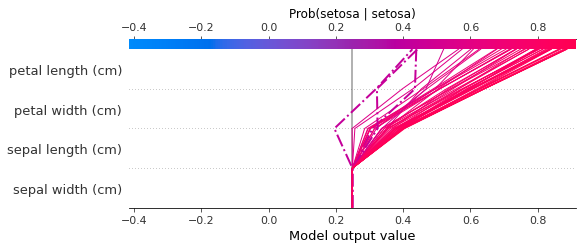

In [520]:
# Let's examine the setosa class samples that the model DID NOT correctly assign to setosa
mask = y == target_class
incorrect = model.predict(X_background[mask]) == False

plt.figure()
plt.title('Prob({} | {})'.format(target_class, target_class))
shap.decision_plot(
    explainer.expected_value[0], 
    shap_values[mask], 
    feature_names=data['feature_names'],
    highlight=incorrect,
    feature_display_range=slice(-1, -37, -1)
)

In [521]:
# There are 3 mis-classifications (in this instance, cases where a setosa was considered "not setosa").  The reason
# is different for each one!  In each case, the lines are otherwise "parallel" to the main set of predictions except
# for one measurement which made it "veer away".

# Overall, the p(setosa|setosa) ~ 0.45 which is very close to 0.5 (would have been correct).  I would conclude that
# this model is fairly good, it just needed to be tuned slightly to fix these mistakes.  However, remember that a 
# SIMCA model uses alpha (Type I error rate) to determine its cutoff.  We purposefully "sacrificed" ~5% (alpha = 0.05)
# of the data to determine that value.  So this looks consistent with that, like the model is working well.

# Other Topics

## Selecting De-correlated Features

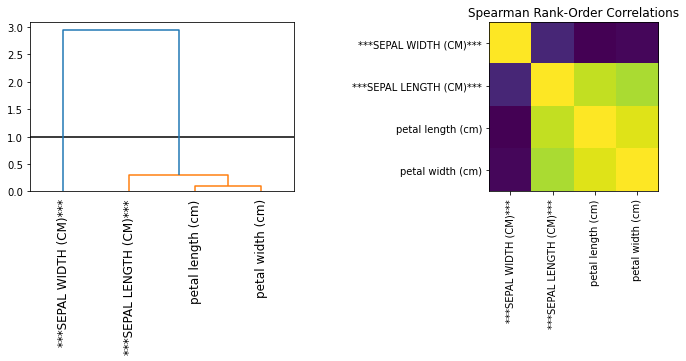

In [530]:
# Petal properties are highly correlated with each other (standardization makes no difference to this calculation)
# and also sepal length, whereas sepal width is not correlated with anything else. Note that sepal width
# was not very relevant for any model we trained.  This calculation just shows correlation not significance.
selected_features, cluster_id_to_feature_ids = \
    ml_inspector.data.InspectData.cluster_collinear(X, 
                                                    feature_names=data['feature_names'], 
                                                    t=1,
                                                    figsize=(10, 5)
                                                    )

100%|██████████| 50/50 [00:00<00:00, 793.00it/s]


Text(0, 0.5, 'Number of Clusters')

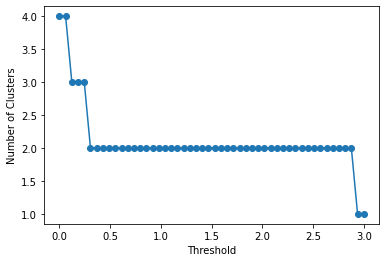

In [534]:
nf = []
for t in tqdm.tqdm(np.linspace(0,3,50)):
    selected_features, cluster_id_to_feature_ids = \
        ml_inspector.data.InspectData.cluster_collinear(X, 
                                                        feature_names=data['feature_names'], 
                                                        t=t,
                                                        display=False)
    nf.append([t, len(selected_features)])
nf = np.array(nf)

plt.plot(nf[:,0], nf[:,1], 'o-')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')

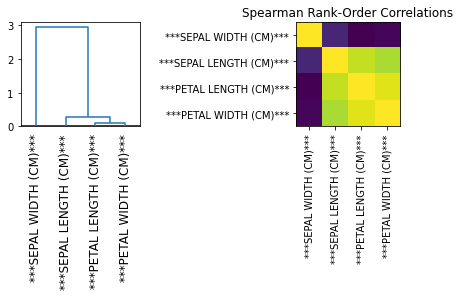

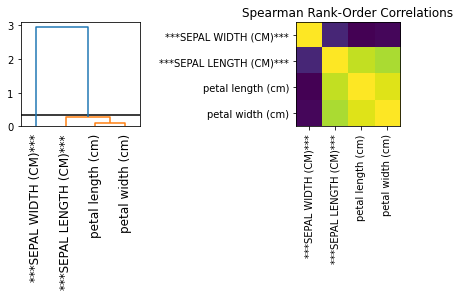

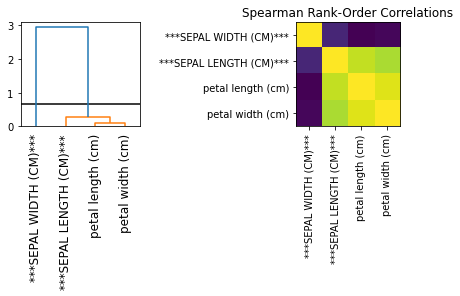

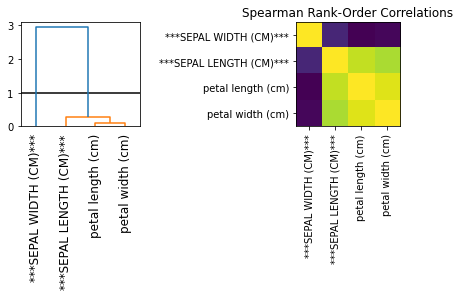

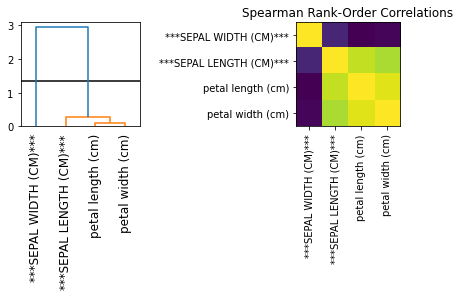

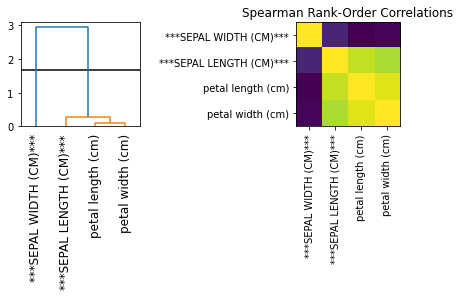

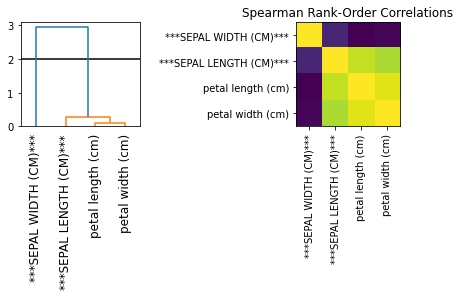

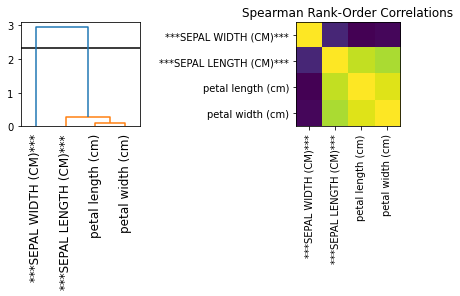

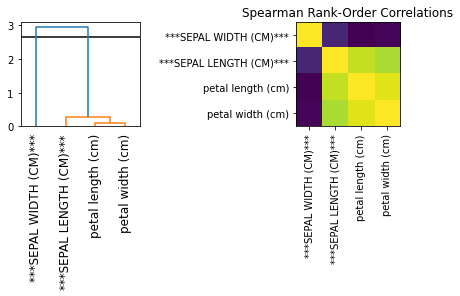

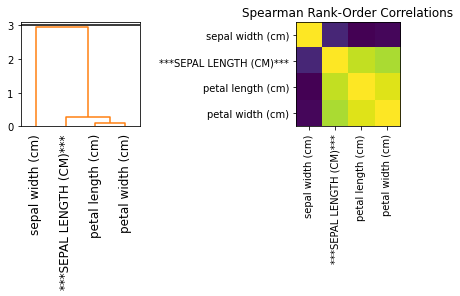

In [535]:
selection = {}
for t in np.linspace(0, 3, 10):
    selected_features, cluster_id_to_feature_ids = \
    ml_inspector.data.InspectData.cluster_collinear(X, 
                                                    feature_names=data['feature_names'], 
                                                    t=t,
                                                    figname=None)
    selection[t] = {'selected_features':selected_features, 'cluster_id_to_feature_ids':cluster_id_to_feature_ids}

## Selecting "Related" Features

Let's try to choose analytes from the different "buckets" that are similar to each other so that the measurements
are easir to make

In [536]:
def petal_info(name):
    if 'petal' in name:
        return 'Petal Property'
    else:
        return 'Not Petal Property'

def width_info(name):
    if 'width' in name:
        return 'Width Property'
    else:
        return 'Not Width Property'

optimal_choices = {}
for t in selection.keys():
    optimal_choices[t] = []
    for i,schema in enumerate([petal_info, width_info]):
        better_choices = ml_inspector.data.InspectData.minimize_cluster_label_entropy(
            selection[t]['cluster_id_to_feature_ids'], 
            schema, 
            pd.DataFrame(X, columns=data['feature_names']),
            cutoff_factor=0.9,
            n_restarts=5, 
            max_iters=100, 
            seed=0, 
            early_stopping=-1, 
            T=0.1)
        optimal_choices[t].append(better_choices)

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 8335.76it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7132.32it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7677.38it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 6652.35it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7691.60it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 6651.82it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7676.11it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7675.55it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7127.72it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7696.11it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 8314.94it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 7945.71it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 6253.53it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 8332.94it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 6654.67it/s]

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 9098.4

MC Steps: 100%|██████████| 100/100 [00:00<00:00, 10005.73it/s]

Restarts: 100%|██████████| 5/5 [00:00<00:00, 56.83it/s]


In [539]:
# For the "petal_info" scheme we are trying to choose features that are, or are not, related to petal properties.
# In this case, since sepal width keeps ending up on its own in one category, when 2+ categories are requested,
# the choise to is always to NOT use the petal props (which means use the other sepal property in this case).
for t in sorted(optimal_choices.keys()):
    print(optimal_choices[t][0])

['sepal width (cm)', 'petal width (cm)', 'sepal length (cm)', 'petal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal width (cm)', 'sepal length (cm)']
['sepal length (cm)']


In [540]:
# For the "width_info" scheme we are trying to choose features that are, or are not, related to width properties.
# In this case, since sepal_width keeps ending up on its own in one category, when 2+ categories are requested,
# the choise to is always to use the petal_width. This is because you are always guaranteed that first category is
# "yes, use width" instead of "no, don't use width", thus the other category(ies) are sought after to match this.
for t in sorted(optimal_choices.keys()):
    print(optimal_choices[t][1])

['sepal width (cm)', 'petal width (cm)', 'sepal length (cm)', 'petal length (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal width (cm)', 'petal width (cm)']
['sepal length (cm)']


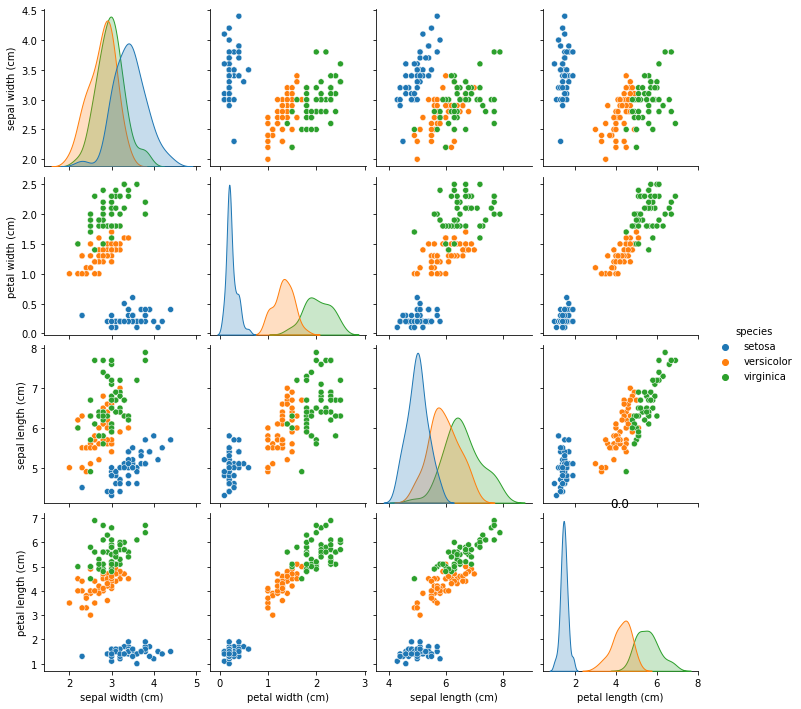

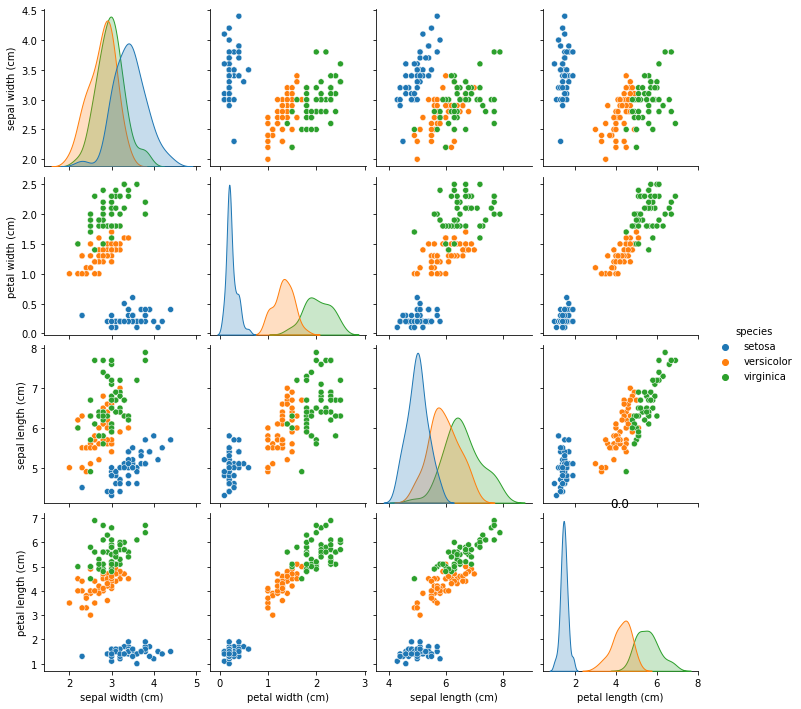

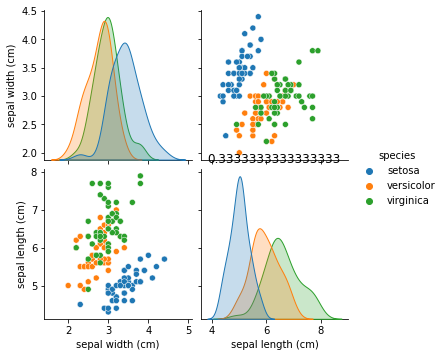

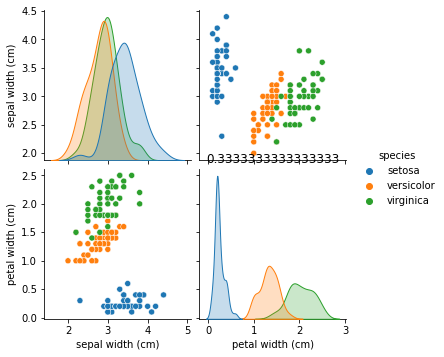

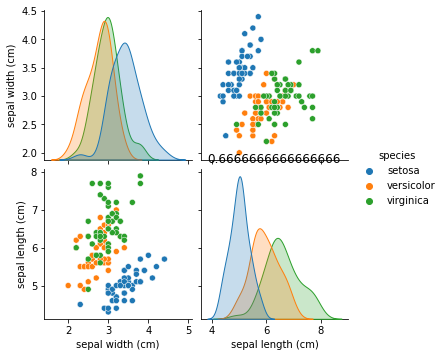

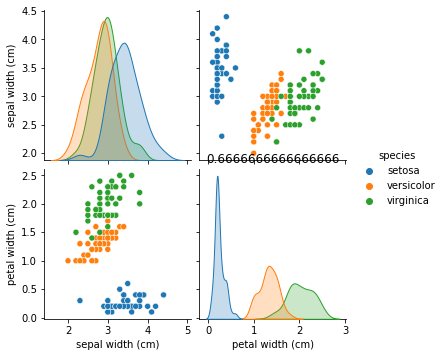

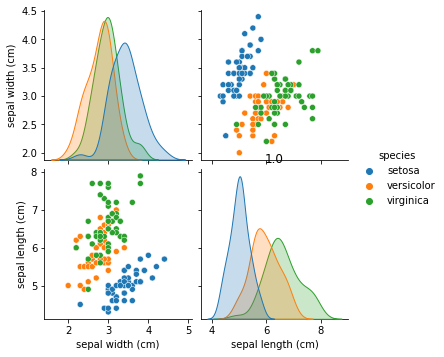

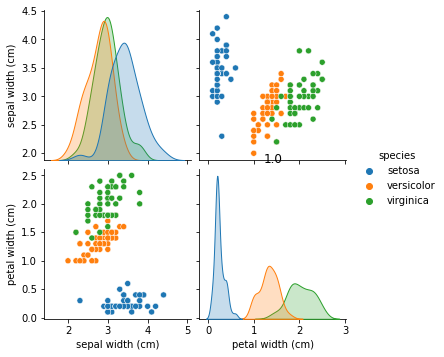

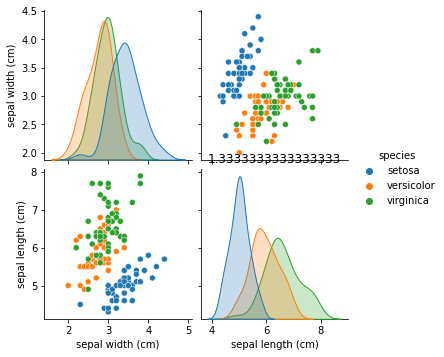

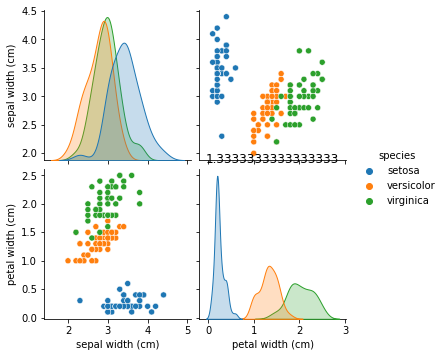

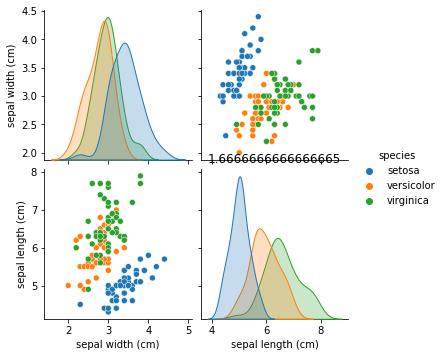

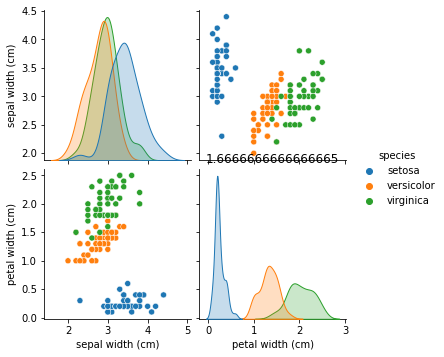

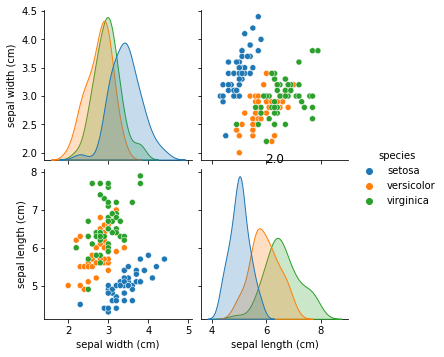

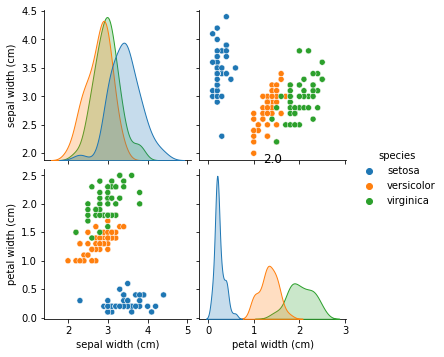

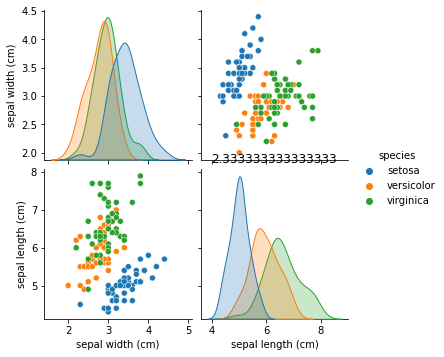

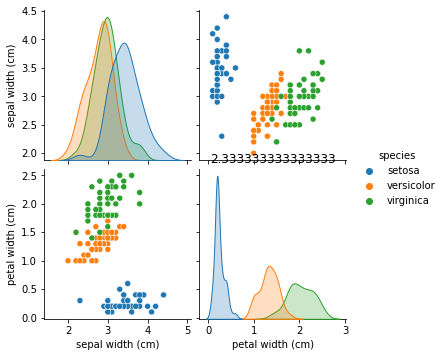

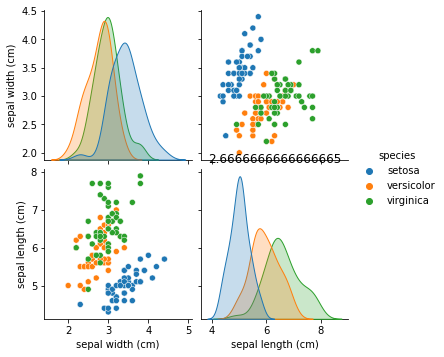

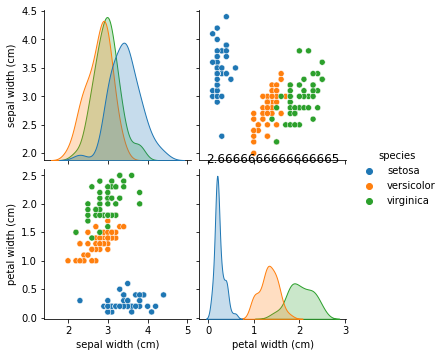

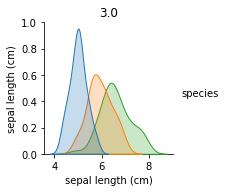

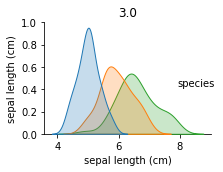

In [551]:
for t in selection.keys():
    for schema_idx in range(len(selection[t])):
        chosen = pd.DataFrame(data=X, columns=data['feature_names'])
        chosen = chosen[optimal_choices[t][schema_idx]]
        chosen['species'] = y
        ml_inspector.data.InspectData.pairplot(chosen, 
                                               vars=optimal_choices[t][schema_idx], 
                                               hue='species')